<a href="https://colab.research.google.com/github/AntonioMastroianni/Text_Mining/blob/main/Text_Mining_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import gzip
nltk.download('punkt')
nltk.download('stopwords')
import string
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
#from keras.layers.embeddings import Embedding
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam



#download(stopwords)

%matplotlib inline
sns.set_style("whitegrid")
plt.style.use("fivethirtyeight")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# import and instantiate CountVectorizer (with the default parameters)
from sklearn.feature_extraction.text import CountVectorizer

vect = CountVectorizer()

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
sms = pd.read_csv("/content/gdrive/MyDrive/Materiale Text Mining/spam.csv", encoding='latin-1')
sms.dropna(how="any", inplace=True, axis=1)
sms.columns = ['label', 'message']

sms.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [5]:
# load nltk's English stopwords as variable called 'stopwords'
sms['message'] = sms['message'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation))) # Removing Puctuation
stopwords = nltk.corpus.stopwords.words('english')
more_stopwords = ['u', 'm', 'c', 'ur', 'dont', 'doin', 'ure', 'im', 'ure', 'n',"'","i'm", "r", "v", "ill"]
stop_words = stopwords + more_stopwords

In [6]:
# load nltk's SnowballStemmer as variabled 'stemmer'
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

In [7]:
# here I define a tokenizer and stemmer which returns the set of stems in the text that it is passed

def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems


def tokenize_only(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

In [8]:
#not super pythonic, no, not at all.
#use extend so it's a big flat list of vocab
totalvocab_stemmed = []
totalvocab_tokenized = []
for i in sms['message']:
    allwords_stemmed = tokenize_and_stem(i) #for each item in 'messages', tokenize/stem
    totalvocab_stemmed.extend(allwords_stemmed) #extend the 'totalvocab_stemmed' list

    allwords_tokenized = tokenize_only(i)
    totalvocab_tokenized.extend(allwords_tokenized)

In [9]:
vocab_frame = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_stemmed)
print('there are ' + str(vocab_frame.shape[0]) + ' items in vocab_frame')

there are 82453 items in vocab_frame


In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer

#define vectorizer parameters
tfidf_vectorizer = TfidfVectorizer(max_df=0.4,
                                 min_df=2, stop_words=stop_words,
                                 use_idf=True, tokenizer=tokenize_and_stem, ngram_range=(1,2))

tfidf_matrix = tfidf_vectorizer.fit_transform(sms['message']) #fit the vectorizer to messages

print(tfidf_matrix.shape)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'m", "'s", 'abov', 'ani', 'becaus', 'befor', 'could', 'doe', 'dure', 'might', 'must', "n't", 'need', 'onc', 'onli', 'ourselv', 'sha', 'themselv', 'veri', 'whi', 'wo', 'would', 'yourselv'] not in stop_words.
  warnings.warn(


(5572, 8862)


In [11]:
terms = tfidf_vectorizer.get_feature_names_out()

In [12]:
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(tfidf_matrix)

In [13]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

num_clusters = 30

km = KMeans(n_clusters=num_clusters)

%time km.fit(tfidf_matrix)

clusters = km.labels_.tolist()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


CPU times: user 3.85 s, sys: 31.5 ms, total: 3.88 s
Wall time: 5.85 s


In [14]:
clusters = km.labels_.tolist()

In [15]:
messages = {'message': sms['message'], 'cluster': clusters}

frame = pd.DataFrame(messages, columns = ['message','cluster'])

In [16]:
message_counts = frame['cluster'].value_counts()

In [17]:
message_counts

3     1890
6      256
16     238
13     213
2      209
10     191
5      179
8      177
9      176
14     171
15     153
27     145
4      135
21     129
7      119
24     118
1      109
25     102
19      96
12      96
17      84
18      84
29      78
0       75
22      67
26      65
28      64
23      61
11      47
20      45
Name: cluster, dtype: int64

In [18]:
silhouette_avg = silhouette_score(tfidf_matrix, clusters)
silhouette_avg

0.019834074060624957

In [19]:
from __future__ import print_function

print("Top terms per cluster:")
print()
# Sort cluster centers by proximity to centroid
order_centroids = km.cluster_centers_.argsort()[:, ::-1]

for i in range(num_clusters):
    print("Cluster %d words: " % i, end='')

    # Collect terms without 'b' prefix in a list
    cluster_terms = []
    for ind in order_centroids[i, :6]:  # Replace 6 with the desired number of words per cluster
        term = vocab_frame.loc[terms[ind].split(' ')].values.tolist()[0][0]
        cluster_terms.append(term)

    # Print the terms without 'b' prefix
    print(', '.join(cluster_terms))
    print()  # add whitespace
    print()  # add whitespace

print()
print()


Top terms per cluster:

Cluster 0 words: way, any, way, text, home, any


Cluster 1 words: ok, ok, ok, thanx, prob, yup


Cluster 2 words: one, need, say, leaving, got, ok


Cluster 3 words: got, still, wat, good, da, lol


Cluster 4 words: ltgt, like, like, ltgt, minute, say


Cluster 5 words: call, account, private, statement, private, identifier


Cluster 6 words: getting, times, text, back, wat, sure


Cluster 7 words: great, think, princess, great, day, wishes


Cluster 8 words: free, text, call, nokia, reply, mobile


Cluster 9 words: love, good, day, miss, kisses, babe


Cluster 10 words: come, come, home, times, want, tomorrow


Cluster 11 words: call, later, sorry, sorry, call, meet


Cluster 12 words: na, gon, gon, wan, wan, getting


Cluster 13 words: see, much, hi, thank, night, good


Cluster 14 words: knows, let, let, lem, lem, want


Cluster 15 words: pls, pick, send, right, pls, cant


Cluster 16 words: go, want, want, got, go, sleeping


Cluster 17 words: happy, new, y

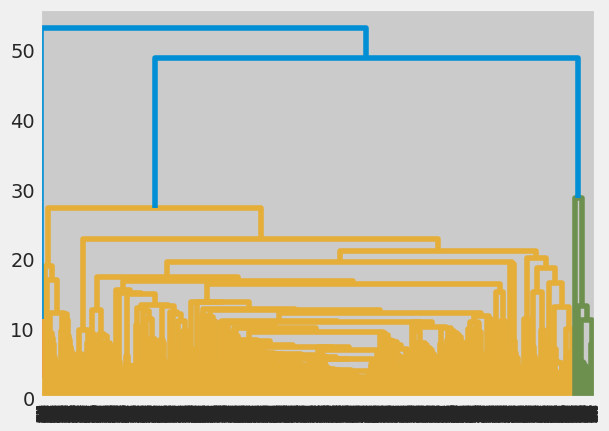

In [27]:
from scipy.cluster.hierarchy import ward, dendrogram, fcluster
import scipy.cluster.hierarchy as sch

linkage_matrix = ward(dist) #define the linkage_matrix using ward clustering pre-computed distances
hclusters = fcluster(linkage_matrix, t=13.5, criterion='distance');
dendrogram = sch.dendrogram(linkage_matrix)
plt.show()

In [28]:
# Create a DataFrame with document and cluster labels
df_clusters = pd.DataFrame({'sms': sms['message'], 'cluster': hclusters})

# Analyze each cluster and find the top 5 words
for cluster_num in range(1, max(hclusters) + 1):
    # Filter data for the current cluster
    cluster_data = df_clusters[df_clusters['cluster'] == cluster_num]

    # Compute TF-IDF for the cluster
    cluster_tfidf_matrix = tfidf_vectorizer.transform(cluster_data['sms'])

    # Sum the TF-IDF scores for each term in the cluster
    term_sum = cluster_tfidf_matrix.sum(axis=0)

    # Get the indices of the top 5 terms
    top_term_indices = term_sum.argsort()[0, -5:]

    # Get the feature names (terms) from the TF-IDF vectorizer
    feature_names = tfidf_vectorizer.get_feature_names_out()

    # Get the top 5 terms
    top_terms = [str(feature_names[index]) for index in top_term_indices]

    # Count of messages in the cluster
    message_count = len(cluster_data)

    # Print the results for each cluster
    print(f"\nCluster {cluster_num}:")
    print(f"  Top 5 terms: {', '.join(top_terms)}")
    print(f"  Message count: {message_count}")


Cluster 1:
  Top 5 terms: [['call' 'sorri' 'later' 'sorri call' 'call later']]
  Message count: 45

Cluster 2:
  Top 5 terms: [['show unredeem' 'privat' 'statement' 'privat account'
  'account statement']]
  Message count: 17

Cluster 3:
  Top 5 terms: [['valid' 'prize' 'guarante' 'guarante call' 'prize guarante']]
  Message count: 22

Cluster 4:
  Top 5 terms: [['claim' 'prize' 'pleas' 'pleas call' 'call']]
  Message count: 276

Cluster 5:
  Top 5 terms: [['like' 'like ltgt' 'min' 'ltgt min' 'ltgt']]
  Message count: 138

Cluster 6:
  Top 5 terms: [['stop' 'repli' 'txt' 'week' 'free']]
  Message count: 248

Cluster 7:
  Top 5 terms: [['happi' 'happi new' 'year' 'new year' 'new']]
  Message count: 35

Cluster 8:
  Top 5 terms: [['think' 'would like' 'would' 'feel' 'like']]
  Message count: 84

Cluster 9:
  Top 5 terms: [['shall' 'time get' 'didnt get' 'time' 'get']]
  Message count: 97

Cluster 10:
  Top 5 terms: [['time' 'think' 'well' 'love' 'good']]
  Message count: 530

Cluster 11

In [32]:
hsilhouette_avg = silhouette_score(tfidf_matrix, hclusters)
print(f"\nSilhouette Score for the Hierarchical Clustering: {hsilhouette_avg}")


Silhouette Score for the Hierarchical Clustering: 0.009985645114639053
